In [2]:
"""

import numpy as np
from ecg_detectors import Detectors  # or your QRS detection library

BASIC_SRATE = 128
signal_pad_samples = 10
signal_pad = np.zeros(signal_pad_samples)  # Pad to help detect early peaks
scd_30_denoised_ = ...  # Your denoised 30-min ECG segment

# Initialize the detectors at the given sampling rate
detector_obj = Detectors(BASIC_SRATE)

# Dictionary of detector functions
detectors = {
    'pan_tompkins_detector': detector_obj.pan_tompkins_detector,
    'hamilton_detector': detector_obj.hamilton_detector,
    'christov_detector': detector_obj.christov_detector,
    'engzee_detector': detector_obj.engzee_detector,
    'swt_detector': detector_obj.swt_detector,
    'two_average_detector': detector_obj.two_average_detector,
}

# Dictionary to store the resulting R-peak indices from each detector
r_peaks_dict = {}

# Apply each detector function, store R-peak indices
for detector_name, detector_func in detectors.items():
    # Concatenate padding + signal, then subtract the pad length from each peak index
    r_peaks = np.array(detector_func(np.hstack((signal_pad, scd_30_denoised_)) )) - signal_pad_samples
    r_peaks_dict[detector_name] = r_peaks

# r_peaks_dict now contains R-peak indices for each detector.
# Example usage:
# r_peaks_pan = r_peaks_dict['pan_tompkins_detector']
# Pass r_peaks_pan to your feature extraction code
print("Detected R-peaks (no visualization):")
for name, peaks in r_peaks_dict.items():
    print(f"{name} -> found {len(peaks)} R-peaks: indices sample excerpt = {peaks[:10]} ...")

"""

'\n\nimport numpy as np\nfrom ecg_detectors import Detectors  # or your QRS detection library\n\nBASIC_SRATE = 128\nsignal_pad_samples = 10\nsignal_pad = np.zeros(signal_pad_samples)  # Pad to help detect early peaks\nscd_30_denoised_ = ...  # Your denoised 30-min ECG segment\n\n# Initialize the detectors at the given sampling rate\ndetector_obj = Detectors(BASIC_SRATE)\n\n# Dictionary of detector functions\ndetectors = {\n    \'pan_tompkins_detector\': detector_obj.pan_tompkins_detector,\n    \'hamilton_detector\': detector_obj.hamilton_detector,\n    \'christov_detector\': detector_obj.christov_detector,\n    \'engzee_detector\': detector_obj.engzee_detector,\n    \'swt_detector\': detector_obj.swt_detector,\n    \'two_average_detector\': detector_obj.two_average_detector,\n}\n\n# Dictionary to store the resulting R-peak indices from each detector\nr_peaks_dict = {}\n\n# Apply each detector function, store R-peak indices\nfor detector_name, detector_func in detectors.items():\n    # 

In [10]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import medfilt
import pywt
from ecgdetectors import Detectors
from scipy.signal import resample_poly

scd_data = {
 './data/scddb/30': '07:54:33',
 './data/scddb/31': '13:42:24',
 './data/scddb/32': '16:45:18',
 './data/scddb/33': '04:46:19',
 './data/scddb/34': '06:35:44',
 './data/scddb/35': '24:34:56',
 './data/scddb/36': '18:59:01',
 './data/scddb/37': '01:31:13',
 './data/scddb/38': '08:01:54',
 './data/scddb/39': '04:37:51',
 './data/scddb/41': '02:59:24',
 './data/scddb/43': '15:37:11',
 './data/scddb/44': '19:38:45',
 './data/scddb/45': '18:09:17',
 './data/scddb/46': '03:41:47',
 './data/scddb/47': '06:13:01',
 './data/scddb/48': '02:29:40',
 './data/scddb/50': '11:45:43',
 './data/scddb/51': '22:58:23',
 './data/scddb/52': '02:32:40'}


fs=250


def hms_to_seconds(hms):
    h, m, s = hms.split(':')
    return int(h)*3600 + int(m)*60 + int(s)

def extract_before_onset_VF(vfon_dict, minutes_before=30):
    ecg_data_map = {} 

    for record_path, vf_onset_str in vfon_dict.items():
        # record_path might be '.data/scddb/30'
        record_dir, record_name = os.path.split(record_path)

        # 2) Convert dictionary's VF onset to seconds
        vf_onset_original_sec = hms_to_seconds(vf_onset_str)

        vfon_onset_original_sample = vf_onset_original_sec * fs

        seg_len_samples = int(minutes_before * 60 * fs)

        start_sample = vfon_onset_original_sample - seg_len_samples

         # read .dat between those sample indices
        try:
            #record_dat_path = os.path.join(record_dir, record_name)  # base path
            record_path_dat = os.path.join(record_dir, record_name)
            segment = wfdb.rdrecord(record_path_dat, sampfrom=start_sample, sampto=vfon_onset_original_sample)
            
        except Exception as e:
            print(f"[ERROR] Failed to read record {record_dat_path}: {e}")
            continue

        # Retrieve the raw signal data as a NumPy array
        if segment.p_signal is not None:
            arr = segment.p_signal[:,0]
            ecg_data_map[record_name] = arr
            print(f"[OK] Extracted 30-min for {record_name}: shape={arr.shape}")
        else:
            print(f"[WARNING] No p_signal found for {record_name}")

    return ecg_data_map

def segment_ecg(ecg_segment, segment_duration_sec=300, fs=250):
    samples_per_segment = segment_duration_sec * fs
    segments = np.array_split(ecg_segment, len(ecg_segment) // samples_per_segment)
    return segments

def resample_ecg(ecg_signal, orig_fs, target_fs):
    """
    Resample ECG signal from orig_fs to target_fs using polyphase filtering.
    ecg_signal: 1D (or 2D) numpy array (samples x channels)
    """
    # For example, if orig_fs=250, target_fs=128:
    # up = 128, down = 250
    up = target_fs
    down = orig_fs

    if ecg_signal.ndim == 1:
        ecg_resampled = resample_poly(ecg_signal, up, down)
    else:
        # If multi-channel, resample each column
        ecg_resampled = np.array([
            resample_poly(ecg_signal[:, ch], up, down) 
            for ch in range(ecg_signal.shape[1])
        ]).T

    return ecg_resampled

def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = pywt.wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  


In [42]:
def r_peak_finder(ecg_sig):
    BASIC_SRATE = 128
    signal_pad_samples = 10
    signal_pad = np.zeros(signal_pad_samples)  # Pad to help detect early peaks
    scd_30_denoised_ = ...  # Your denoised 30-min ECG segment
    
    # Initialize the detectors at the given sampling rate
    detector_obj = Detectors(BASIC_SRATE)
    
    # Dictionary of detector functions
    detectors = {
        'pan_tompkins_detector': detector_obj.pan_tompkins_detector,
        'hamilton_detector': detector_obj.hamilton_detector,
        'christov_detector': detector_obj.christov_detector,
        'engzee_detector': detector_obj.engzee_detector,
        'swt_detector': detector_obj.swt_detector,
        'two_average_detector': detector_obj.two_average_detector,
    }
    
    r_peaks = np.array(detector_obj.swt_detector(np.hstack((signal_pad, ecg_sig)) )) - signal_pad_samples
    return r_peaks

In [54]:
def compute_hrv_features(r_peaks, fs=128):
    """
    Time-domain HRV features from R-peaks.
    Returns a dict with:
      MeanRR, RMSDD, pNN50, SDRR, CVRR, NN50, MinRR, MaxRR
    """
    features = {
        'MeanRR': 0.0,
        'RMSDD': 0.0,
        'pNN50': 0.0,
        'SDRR': 0.0,
        'CVRR': 0.0,
        'NN50': 0,
        'MinRR': 0.0,
        'MaxRR': 0.0
    }

    rr_samples = np.diff(r_peaks)
    rr_ms = (rr_samples / fs) * 1000.0  # convert to ms

    mean_rr = np.mean(rr_ms)
    sdrr = np.std(rr_ms, ddof=1) if len(rr_ms) > 1 else 0.0
    min_rr = np.min(rr_ms)
    max_rr = np.max(rr_ms)

    rr_diffs = np.diff(rr_ms)
    rmssd = np.sqrt(np.mean(rr_diffs**2)) if len(rr_diffs) > 0 else 0.0
    nn50 = np.sum(np.abs(rr_diffs) > 50)
    pnn50 = (nn50 / len(rr_diffs)) * 100 if len(rr_diffs) > 0 else 0.0

    cvrr = (sdrr / mean_rr * 100.0) if mean_rr else 0.0

    features['MeanRR'] = mean_rr / 1000.0
    features['RMSDD'] = rmssd / 1000.0
    features['pNN50'] = pnn50 / 1000.0
    features['SDRR'] = sdrr / 1000.0
    features['CVRR'] = cvrr / 1000.0 
    features['NN50'] = nn50 / 1000.0
    features['MinRR'] = min_rr / 1000.0 
    features['MaxRR'] = max_rr / 1000.0
    
    return features

# Ex 

In [19]:
onsetVF_30min_scd = extract_before_onset_VF(scd_data, minutes_before=30)

[OK] Extracted 30-min for 30: shape=(450000,)
[OK] Extracted 30-min for 31: shape=(450000,)
[OK] Extracted 30-min for 32: shape=(450000,)
[OK] Extracted 30-min for 33: shape=(450000,)
[OK] Extracted 30-min for 34: shape=(450000,)
[OK] Extracted 30-min for 35: shape=(450000,)
[OK] Extracted 30-min for 36: shape=(450000,)
[OK] Extracted 30-min for 37: shape=(450000,)
[OK] Extracted 30-min for 38: shape=(450000,)
[OK] Extracted 30-min for 39: shape=(450000,)
[OK] Extracted 30-min for 41: shape=(450000,)
[OK] Extracted 30-min for 43: shape=(450000,)
[OK] Extracted 30-min for 44: shape=(450000,)
[OK] Extracted 30-min for 45: shape=(450000,)
[OK] Extracted 30-min for 46: shape=(450000,)
[OK] Extracted 30-min for 47: shape=(450000,)
[OK] Extracted 30-min for 48: shape=(450000,)
[OK] Extracted 30-min for 50: shape=(450000,)
[OK] Extracted 30-min for 51: shape=(450000,)
[OK] Extracted 30-min for 52: shape=(450000,)


In [25]:
onset30_6segments_5mins = segment_ecg(onsetVF_30min_scd['30'])
onset30_6segments_5mins

[array([ 0.11   ,  0.11875,  0.13   , ..., -0.23125, -0.2275 , -0.21625]),
 array([-0.2075 , -0.1975 , -0.185  , ..., -0.21625, -0.2175 , -0.22375]),
 array([-0.2275 , -0.23125, -0.23625, ..., -0.11875, -0.11125, -0.10625]),
 array([-0.10875, -0.105  , -0.1025 , ..., -0.005  ,  0.02   ,  0.0525 ]),
 array([ 0.11375,  0.1975 ,  0.315  , ..., -0.09625, -0.09625, -0.0975 ]),
 array([-0.0975 , -0.09125, -0.09875, ..., -0.03625, -0.03875, -0.0425 ])]

In [27]:
first_5min_of30 = onset30_6segments_5mins[5]
first_5min_of30

array([-0.0975 , -0.09125, -0.09875, ..., -0.03625, -0.03875, -0.0425 ])

In [31]:
ecg_downsampled_250_to_128 = resample_ecg(first_5min_of30, 250, 128)
ecg_downsampled_250_to_128

array([-0.0715235 , -0.10325322, -0.09964019, ..., -0.03350907,
       -0.03113093, -0.04236117])

In [33]:
first_5min_of30 = ecg_downsampled_250_to_128
first_5min_of30

array([-0.0715235 , -0.10325322, -0.09964019, ..., -0.03350907,
       -0.03113093, -0.04236117])

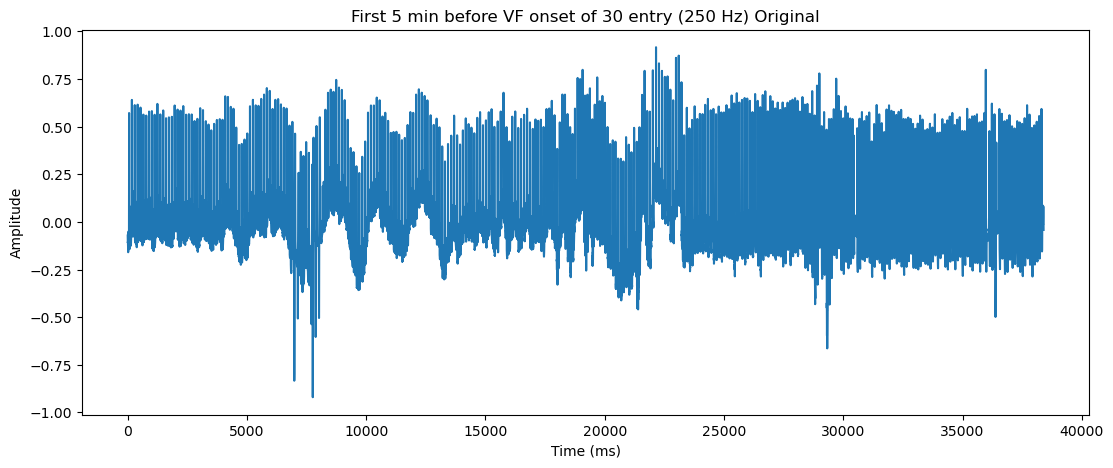

In [35]:
plt.figure(figsize=(13, 5))
plt.subplot()
plt.plot(first_5min_of30)
plt.title('First 5 min before VF onset of 30 entry (250 Hz) Original')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

In [38]:
scd_30_denoised_sym20 = denoise_signal(first_5min_of30, 'sym20', 8, -5 , 5)

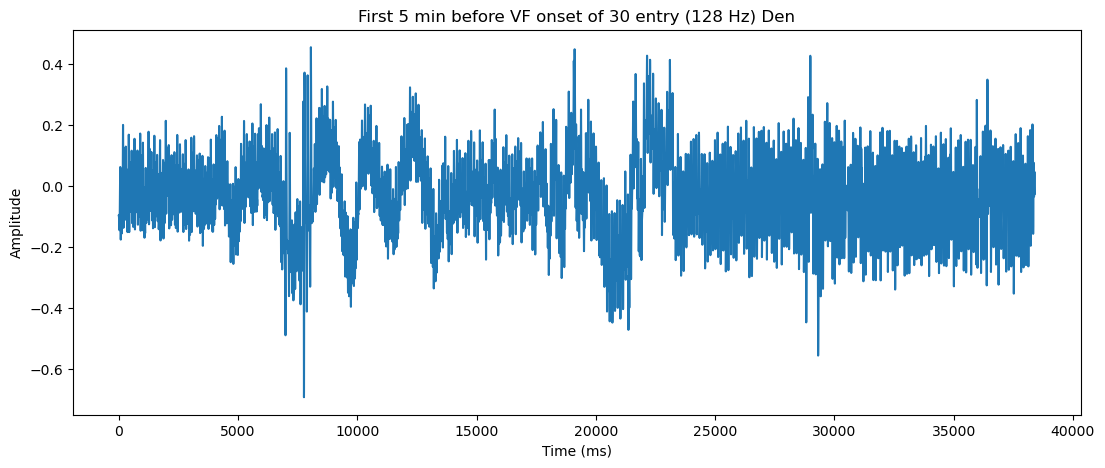

In [40]:
plt.figure(figsize=(13, 5))
plt.subplot()
plt.plot(scd_30_denoised_sym20)
plt.title('First 5 min before VF onset of 30 entry (128 Hz) Den')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

In [44]:
r_peaks = r_peak_finder(scd_30_denoised_sym20)
r_peaks

array([   29,    79,   118,   158,   200,   414,   454,   574,   654,
         694,   799,   894,   934,  1006,  1178,  1262,  1302,  1486,
        1526,  1599,  1726,  1766,  1871,  1966,  2006,  2111,  2216,
        2366,  2446,  2486,  2568,  2703,  2798,  2958,  3038,  3078,
        3150,  3295,  3335,  3406,  3502,  3542,  3674,  3772,  3854,
        3964,  4028,  4127,  4223,  4318,  4358,  4429,  4470,  4686,
        4798,  4894,  5005,  5116,  5246,  5286,  5419,  5517,  5598,
        5638,  5710,  5871,  5951,  6109,  6190,  6230,  6302,  6342,
        6462,  6542,  6582,  6653,  6782,  6822,  6895,  7010,  7136,
        7184,  7279,  7319,  7406,  7517,  7614,  7655,  7768,  7801,
        8047,  8284,  8397,  8438,  8510,  8550,  8732,  8893,  8974,
        9272,  9342,  9488,  9593,  9726,  9950, 10108, 10318, 10476,
       10558, 10703, 10814, 10921, 11070, 11181, 11262, 11302, 11373,
       11535, 11614, 11724, 11886, 11966, 12006, 12125, 12206, 12246,
       12369, 12446,

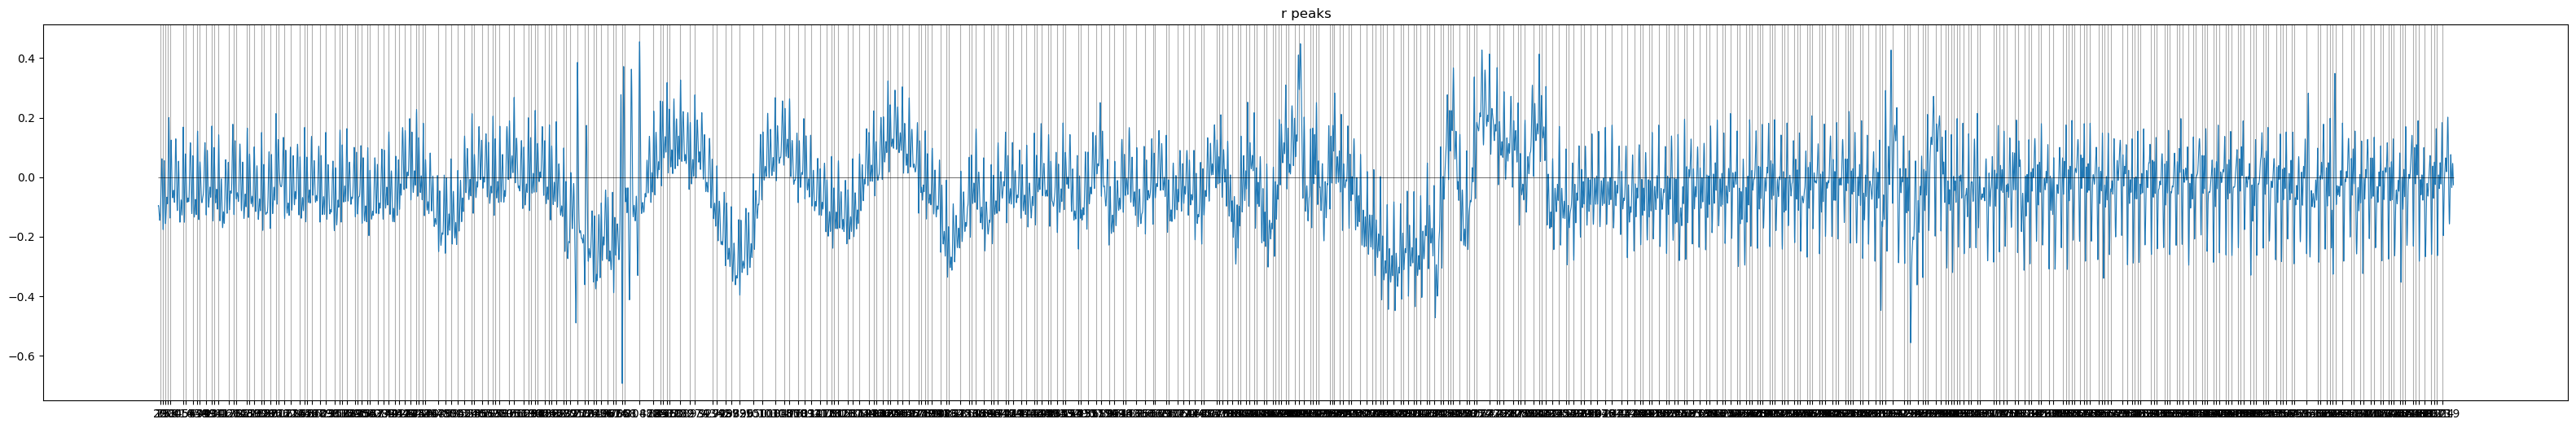

In [46]:
plt.figure(figsize=(40,6))
plt.title('r peaks')
plt.plot(scd_30_denoised_sym20,color='tab:blue',linewidth=0.8)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks)
plt.grid(axis='x')
plt.show()

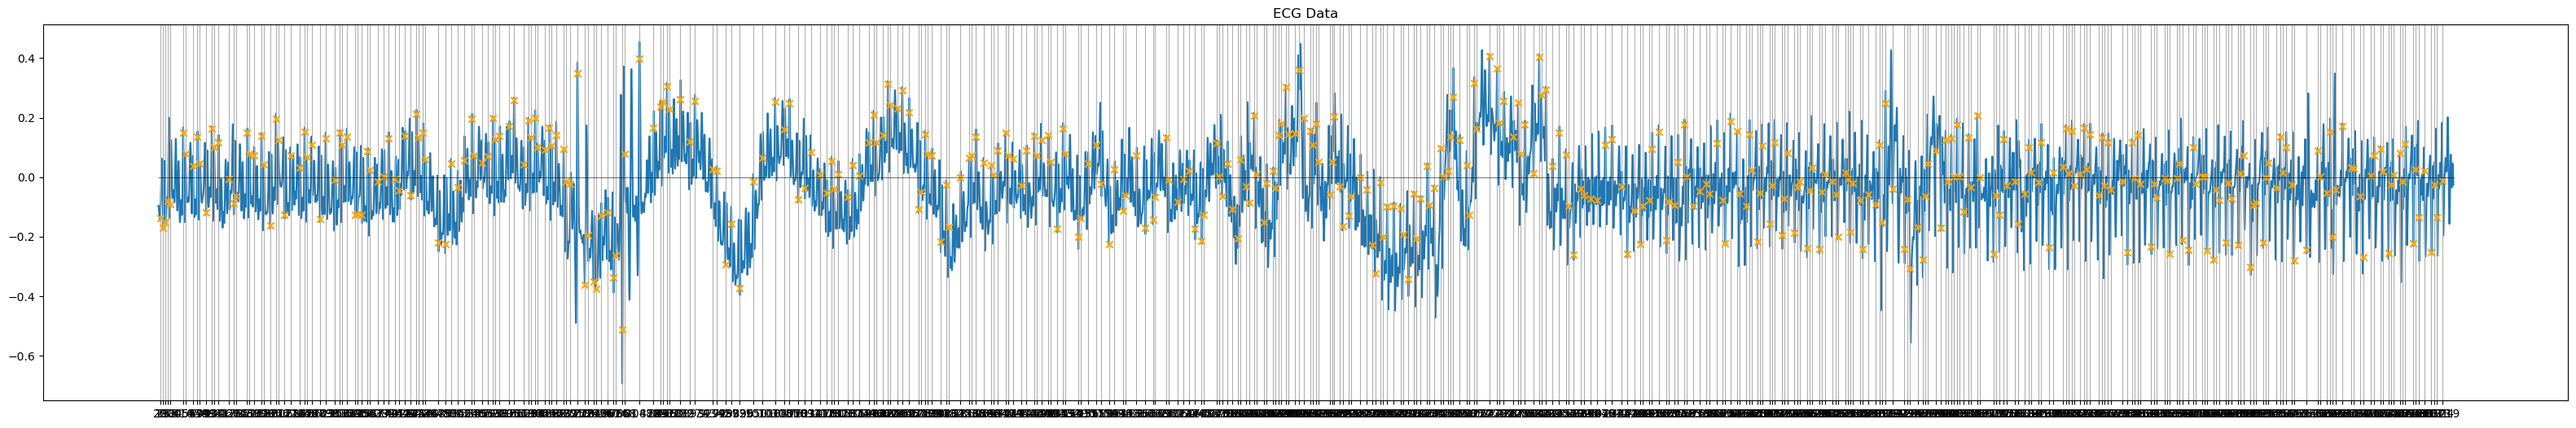

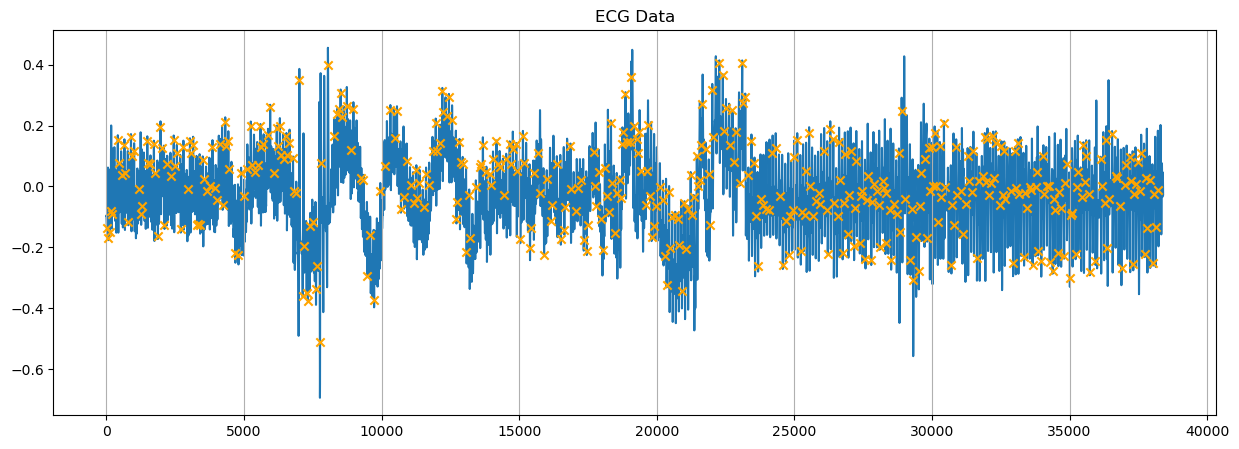

In [48]:
plt.figure(figsize=(40,6))
plt.title('ECG Data')
plt.plot(scd_30_denoised_sym20, zorder=1)
plt.scatter(r_peaks, scd_30_denoised_sym20[r_peaks], color='orange', marker='x', label='R-peaks', zorder=2)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks)
plt.grid(axis='x')
plt.show()

plt.figure(figsize=(15,5))
plt.title('ECG Data')
plt.scatter(r_peaks, scd_30_denoised_sym20[r_peaks], color='orange', marker='x', label='R-peaks', zorder=2)
plt.plot(scd_30_denoised_sym20, zorder=1)
plt.grid(axis='x')
plt.show()

In [56]:
features = compute_hrv_features(r_peaks)
features

{'MeanRR': 0.6765518707482993,
 'RMSDD': 0.5327655573245871,
 'pNN50': 0.0915909090909091,
 'SDRR': 0.3592838862047769,
 'CVRR': 0.05310515006150105,
 'NN50': 0.403,
 'MinRR': 0.2578125,
 'MaxRR': 2.328125}

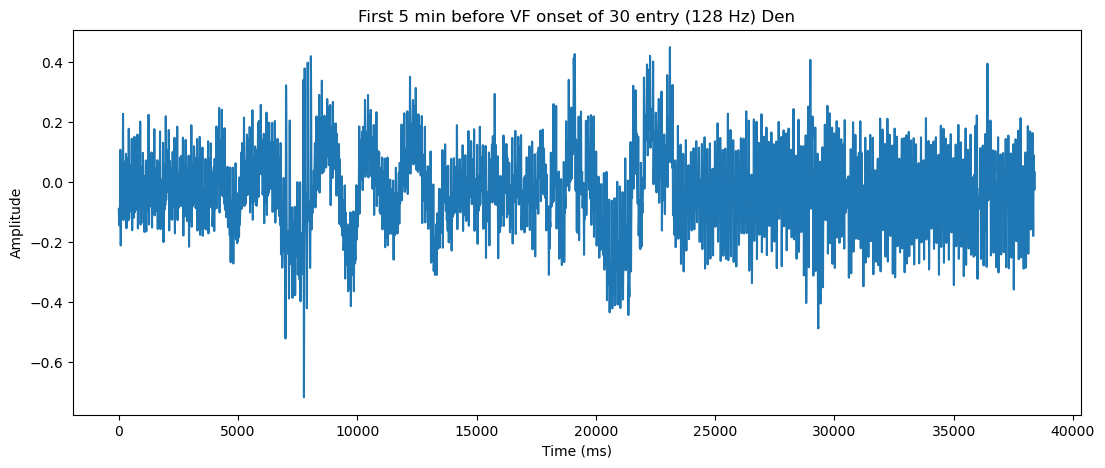

------------------------------------------------------------------------------------------------------------------------------------------------------
[   58   101   170   314   410   538   577   650   778   890  1050  1146
  1242  1386  1482  1626  1722  1850  1962  2090  2234  2330  2369  2442
  2602  2682  2794  2922  2961  3034  3194  3274  3386  3498  3642  3738
  3777  3851  3994  4090  4129  4202  4314  4426  4570  4666  4778  4891
  5050  5146  5242  5386  5482  5521  5594  5754  5850  5946  6074  6113
  6186  6299  6426  6465  6538  6651  6698  6778  6922  6981  7131  7174
  7274  7370  7409  7482  7594  7707  7754  7801  7883  7926  8042  8283
  8394  8506  8874  8970  9114  9242  9349  9466  9626  9706  9850  9947
 10074 10218 10314 10442 10555 10602 10682 10794 10954 11034 11073 11146
 11185 11258 11418 11498 11537 11611 11754 11850 11889 11962 12090 12129
 12202 12346 12442 12555 12602 12698 12826 12970 13066 13178 13322 13419
 13466 13562 13675 13722 13803 13930 14043 140

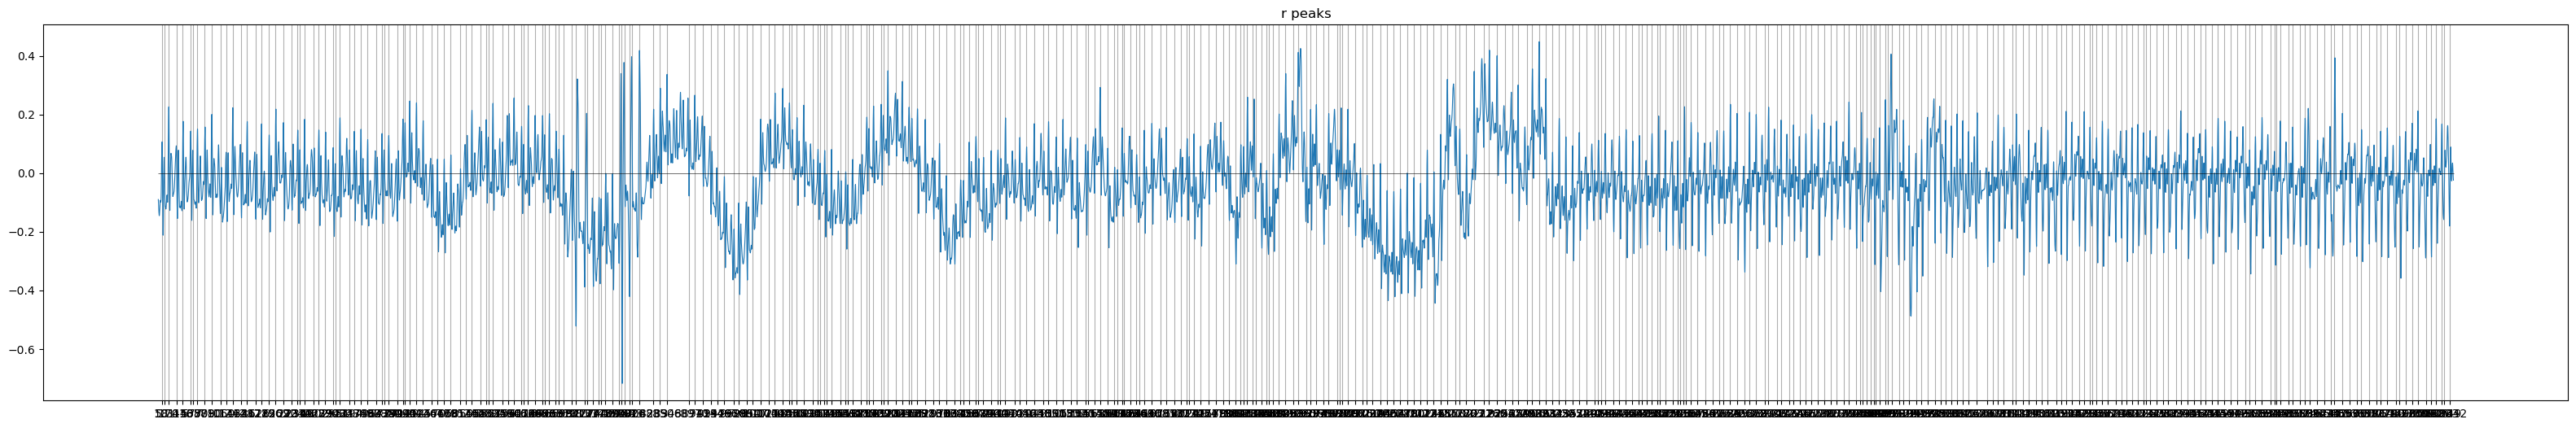

------------------------------------------------------------------------------------------------------------------------------------------------------


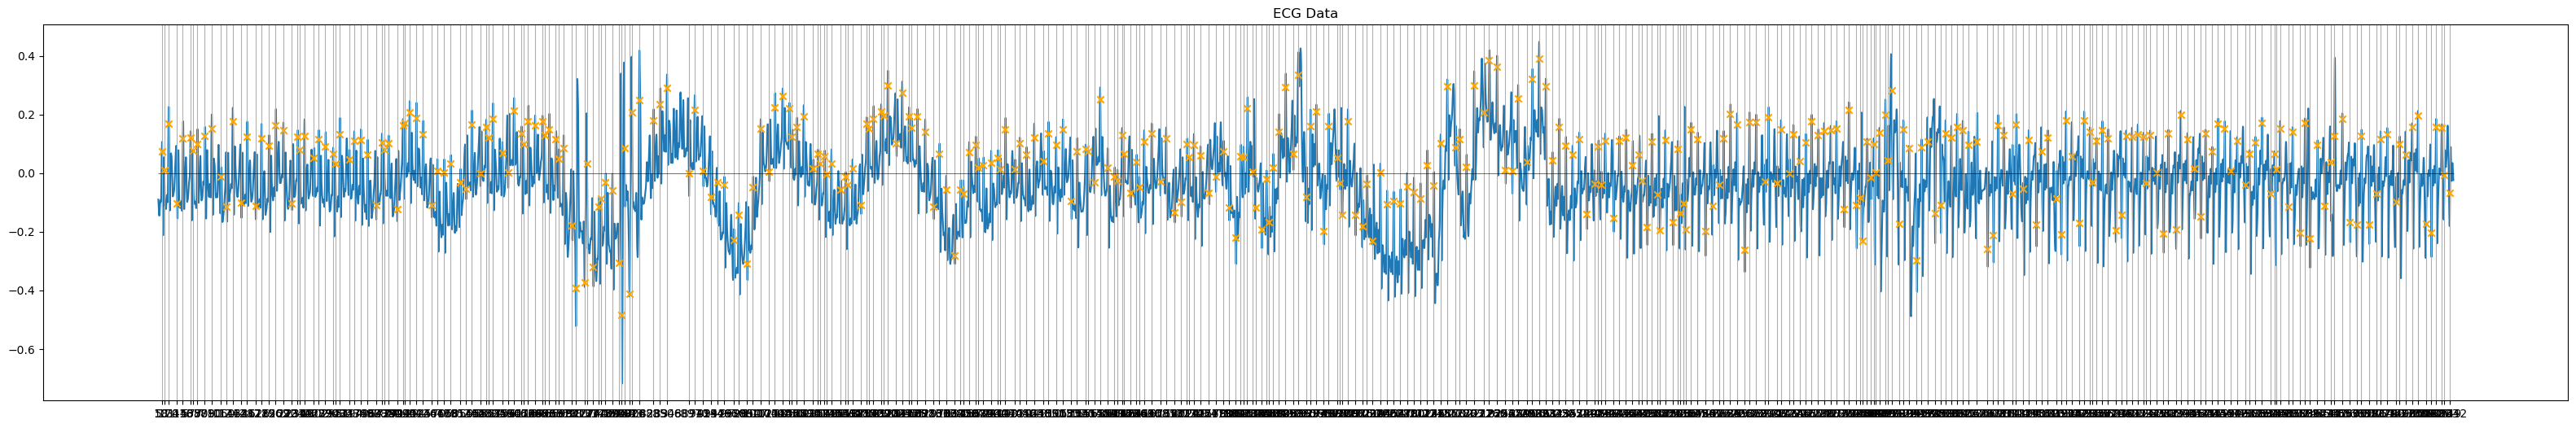

------------------------------------------------------------------------------------------------------------------------------------------------------


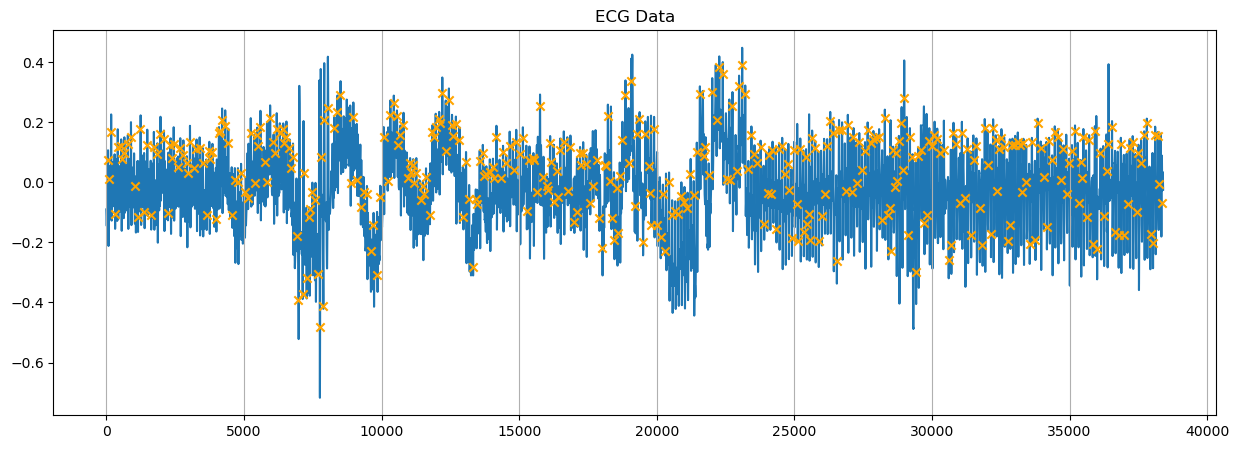

------------------------------------------------------------------------------------------------------------------------------------------------------
{'MeanRR': 0.7768668831168831, 'RMSDD': 0.37959818895053327, 'pNN50': 0.08671875, 'SDRR': 0.27709113153113085, 'CVRR': 0.035667774949989885, 'NN50': 0.333, 'MinRR': 0.3046875, 'MaxRR': 2.875}


In [83]:
def r_peak_finder_for_sym5(ecg_sig):
    BASIC_SRATE = 128
    signal_pad_samples = 10
    signal_pad = np.zeros(signal_pad_samples)  # Pad to help detect early peaks
    scd_30_denoised_ = ...  # Your denoised 30-min ECG segment
    
    # Initialize the detectors at the given sampling rate
    detector_obj = Detectors(BASIC_SRATE)
    
    # Dictionary of detector functions
    detectors = {
        'pan_tompkins_detector': detector_obj.pan_tompkins_detector,
        'hamilton_detector': detector_obj.hamilton_detector,
        'christov_detector': detector_obj.christov_detector,
        'engzee_detector': detector_obj.engzee_detector,
        'swt_detector': detector_obj.swt_detector,
        'two_average_detector': detector_obj.two_average_detector,
    }
    
    r_peaks = np.array(detector_obj.hamilton_detector(np.hstack((signal_pad, ecg_sig)) )) - signal_pad_samples
    return r_peaks


scd_30_denoised_sym5 = denoise_signal(first_5min_of30, 'sym5', 8, -5 , 5)

plt.figure(figsize=(13, 5))
plt.subplot()
plt.plot(scd_30_denoised_sym5)
plt.title('First 5 min before VF onset of 30 entry (128 Hz) Den')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

print('-'*150)


r_peaks_sym5 = r_peak_finder_for_sym5(scd_30_denoised_sym5)
print(r_peaks_sym5)

print('-'*150)

plt.figure(figsize=(40,6))
plt.title('r peaks')
plt.plot(scd_30_denoised_sym5,color='tab:blue',linewidth=0.8)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)



plt.figure(figsize=(40,6))
plt.title('ECG Data')
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)


plt.figure(figsize=(15,5))
plt.title('ECG Data')
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.grid(axis='x')
plt.show()


print('-'*150)



features_sym5 = compute_hrv_features(r_peaks_sym5)
print(features_sym5)

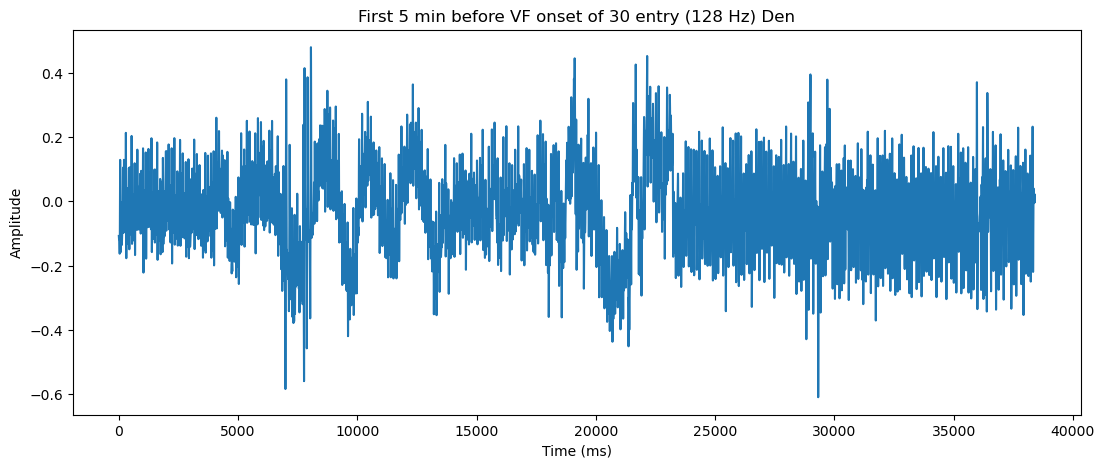

------------------------------------------------------------------------------------------------------------------------------------------------------
[  295   536   662   776  1015  1049  1128  1288  1368  1493  1529  1607
  1769  1974  2009  2088  2184  2215  2295  2328  2453  2489  2536  2567
  2602  2807  2841  2920  3080  3159  3272  3545  3624  3863  3976  4088
  4360  4473  4552  4824  4902  4937  5015  5128  5254  5289  5368  5480
  5640  5719  5958  6072  6232  6311  6424  6584  6663  6698  6824  6904
  6964  7015  7111  7223  7256  7336  7368  7448  7480  7686  7861  7913
  8054  8183  8216  8294  8329  8552  8631  8743  8777  8856  8983  9017
  9096  9223  9351  9591  9752  9832  9959 10199 10361 10440 10567 10680
 10840 10919 11032 11144 11269 11305 11383 11418 11496 11623 11658 11736
 11848 11974 12088 12249 12328 12453 12489 12567 12696 12872 12951 13064
 13112 13190 13225 13303 13431 13687 13814 14055 14216 14295 14408 14535
 14775 15016 15142 15255 15512 15640 15800 158

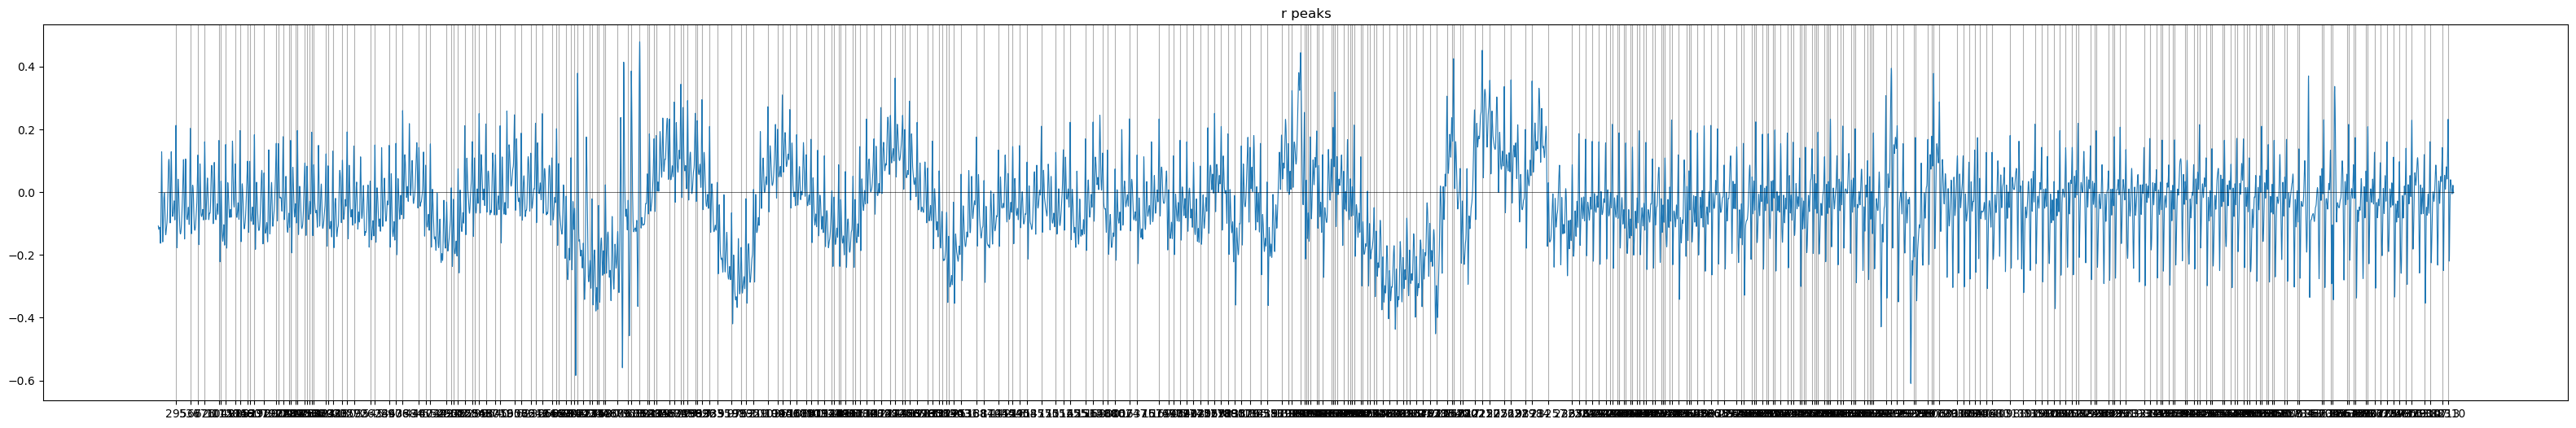

------------------------------------------------------------------------------------------------------------------------------------------------------


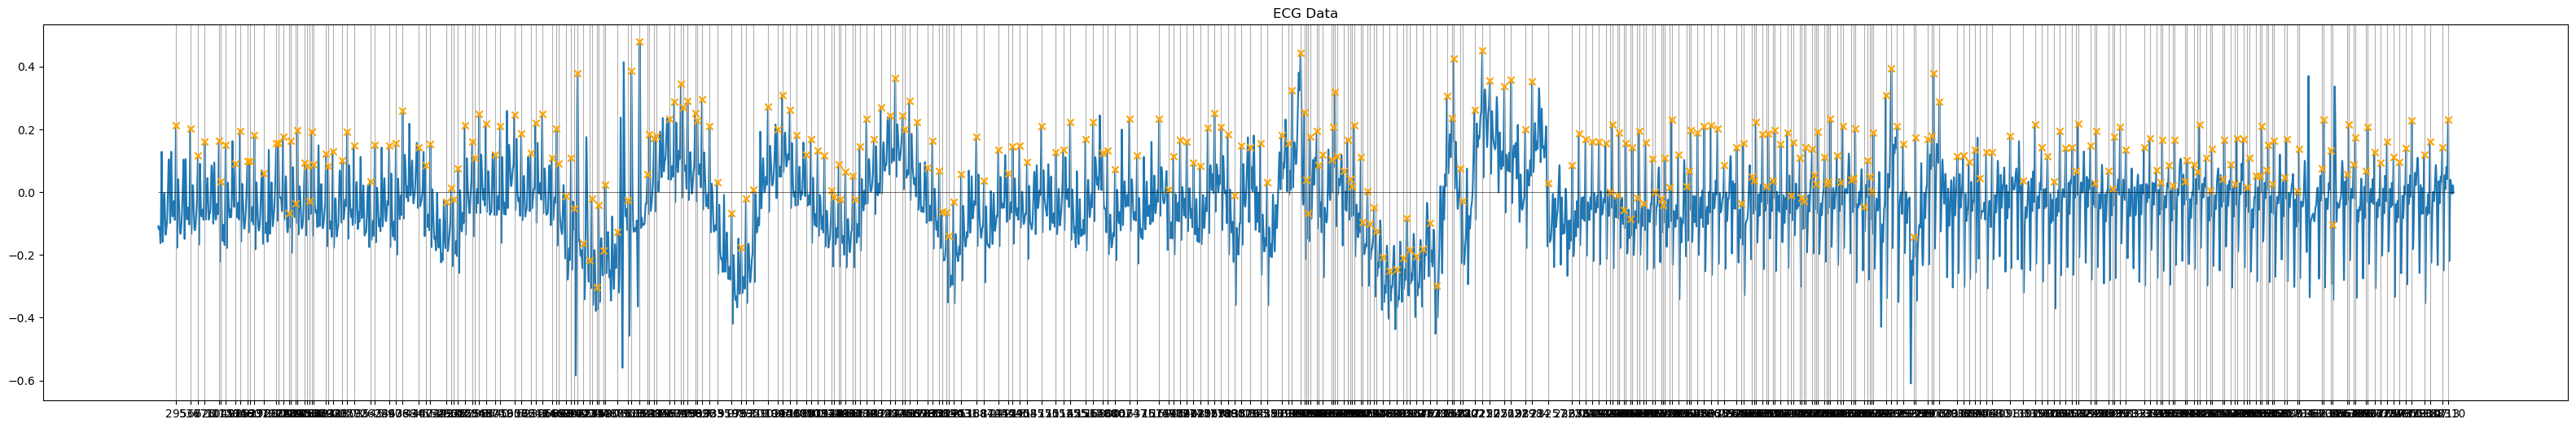

------------------------------------------------------------------------------------------------------------------------------------------------------


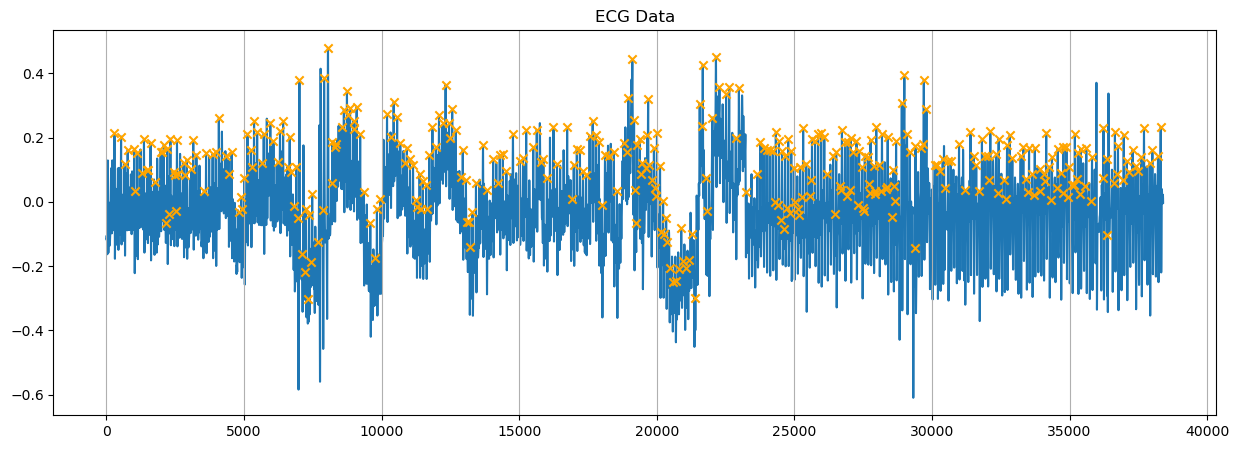

------------------------------------------------------------------------------------------------------------------------------------------------------
{'MeanRR': 0.800518025606469, 'RMSDD': 0.6949280557290504, 'pNN50': 0.08675675675675676, 'SDRR': 0.5160436607894788, 'CVRR': 0.0644637152796811, 'NN50': 0.321, 'MinRR': 0.2265625, 'MaxRR': 3.1171875}


In [135]:
def r_peak_finder_for_sym5(ecg_sig):
    BASIC_SRATE = 128
    signal_pad_samples = 10
    signal_pad = np.zeros(signal_pad_samples)  # Pad to help detect early peaks
    scd_30_denoised_ = ...  # Your denoised 30-min ECG segment
    
    # Initialize the detectors at the given sampling rate
    detector_obj = Detectors(BASIC_SRATE)
    
    # Dictionary of detector functions
    detectors = {
        'pan_tompkins_detector': detector_obj.pan_tompkins_detector,
        'hamilton_detector': detector_obj.hamilton_detector,
        'christov_detector': detector_obj.christov_detector,
        'engzee_detector': detector_obj.engzee_detector,
        'swt_detector': detector_obj.swt_detector,
        'two_average_detector': detector_obj.two_average_detector,
    }
    
    r_peaks = np.array(detector_obj.engzee_detector(np.hstack((signal_pad, ecg_sig)) )) - signal_pad_samples
    return r_peaks


scd_30_denoised_sym5 = denoise_signal(first_5min_of30, 'bior6.8', 9, -4, 6)
plt.figure(figsize=(13, 5))
plt.subplot()
plt.plot(scd_30_denoised_sym5)
plt.title('First 5 min before VF onset of 30 entry (128 Hz) Den')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

print('-'*150)


r_peaks_sym5 = r_peak_finder_for_sym5(scd_30_denoised_sym5)
print(r_peaks_sym5)

print('-'*150)

plt.figure(figsize=(40,6))
plt.title('r peaks')
plt.plot(scd_30_denoised_sym5,color='tab:blue',linewidth=0.8)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)



plt.figure(figsize=(40,6))
plt.title('ECG Data')
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)


plt.figure(figsize=(15,5))
plt.title('ECG Data')
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.grid(axis='x')
plt.show()


print('-'*150)



features_sym5 = compute_hrv_features(r_peaks_sym5)
print(features_sym5)

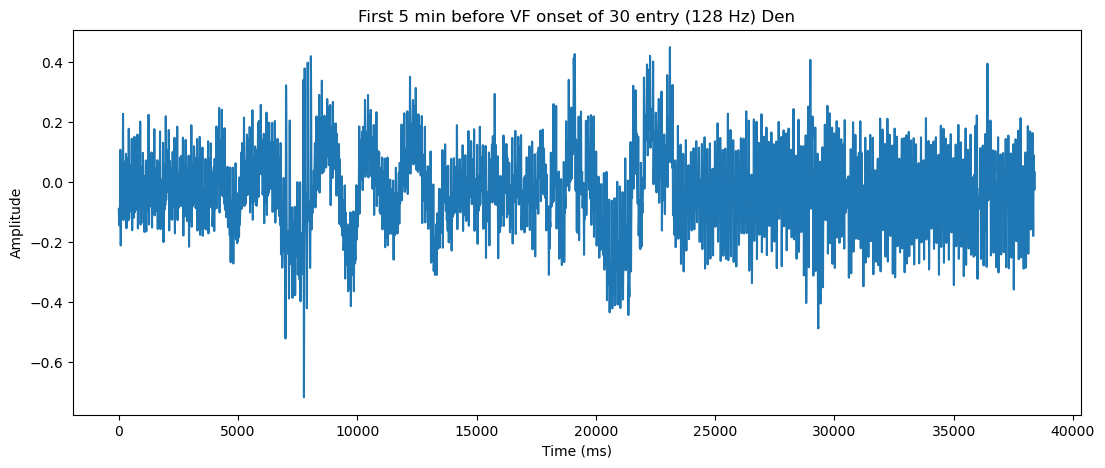

------------------------------------------------------------------------------------------------------------------------------------------------------
[   58   101   170   314   410   538   577   650   778   890  1050  1146
  1242  1386  1482  1626  1722  1850  1962  2090  2234  2330  2369  2442
  2602  2682  2794  2922  2961  3034  3194  3274  3386  3498  3642  3738
  3777  3851  3994  4090  4129  4202  4314  4426  4570  4666  4778  4891
  5050  5146  5242  5386  5482  5521  5594  5754  5850  5946  6074  6113
  6186  6299  6426  6465  6538  6651  6698  6778  6922  6981  7131  7174
  7274  7370  7409  7482  7594  7707  7754  7801  7883  7926  8042  8283
  8394  8506  8874  8970  9114  9242  9349  9466  9626  9706  9850  9947
 10074 10218 10314 10442 10555 10602 10682 10794 10954 11034 11073 11146
 11185 11258 11418 11498 11537 11611 11754 11850 11889 11962 12090 12129
 12202 12346 12442 12555 12602 12698 12826 12970 13066 13178 13322 13419
 13466 13562 13675 13722 13803 13930 14043 140

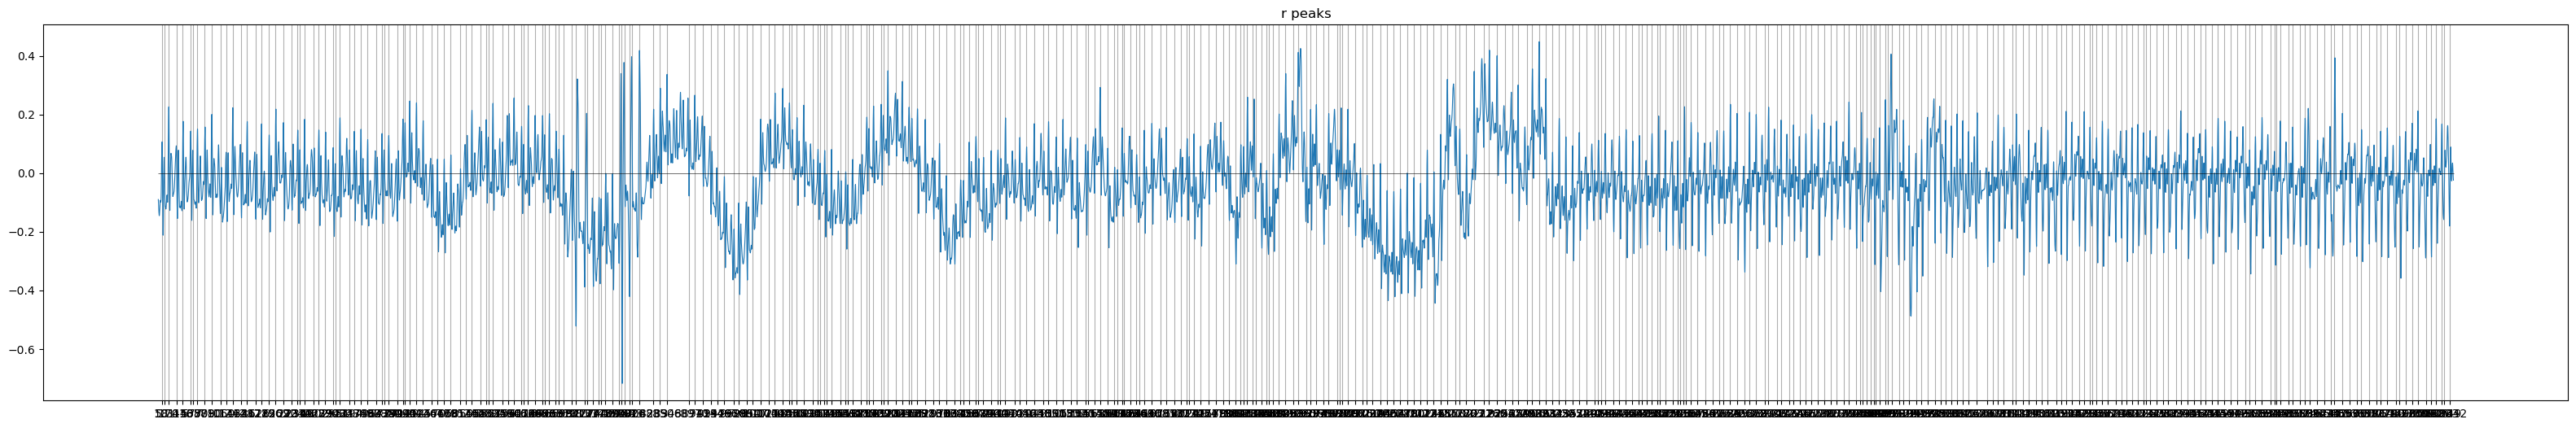

------------------------------------------------------------------------------------------------------------------------------------------------------


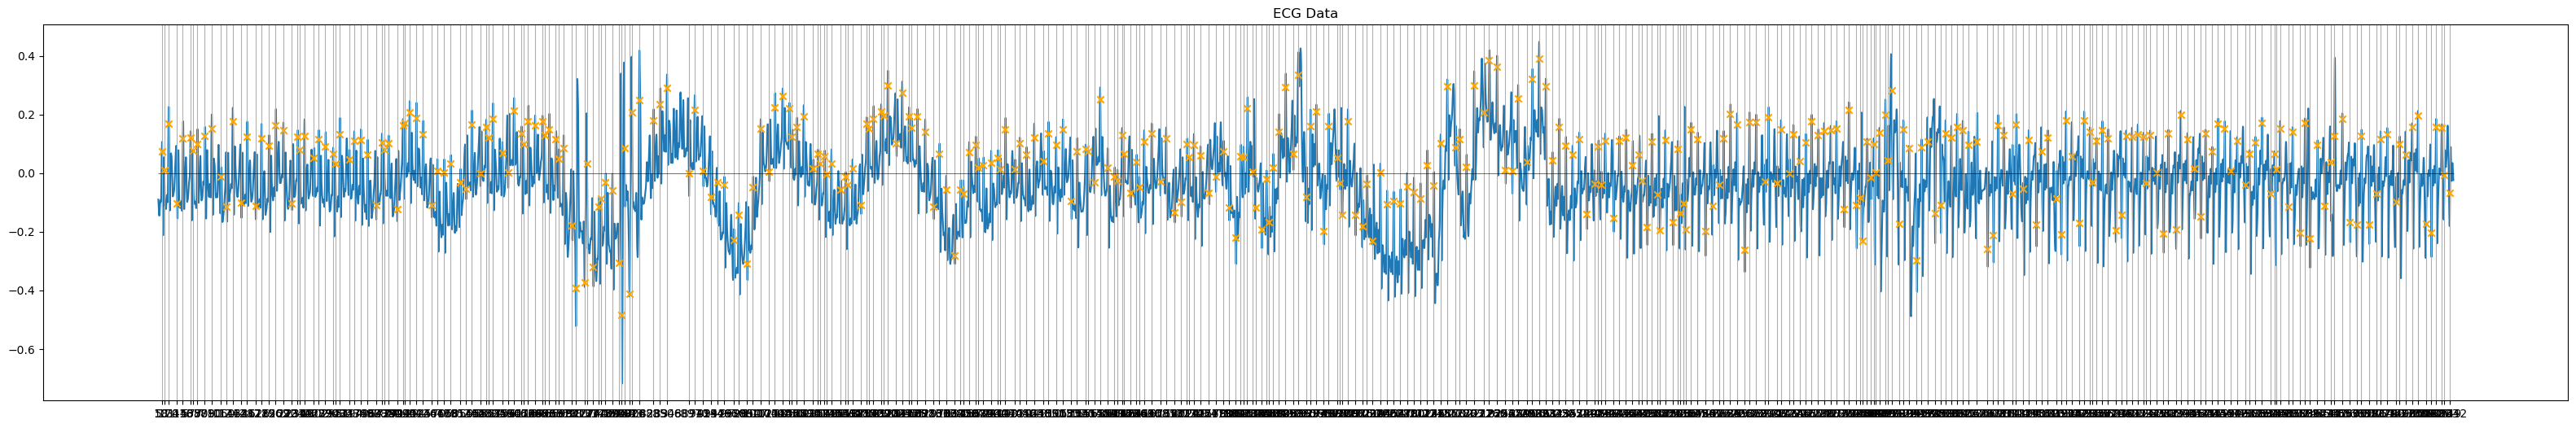

------------------------------------------------------------------------------------------------------------------------------------------------------


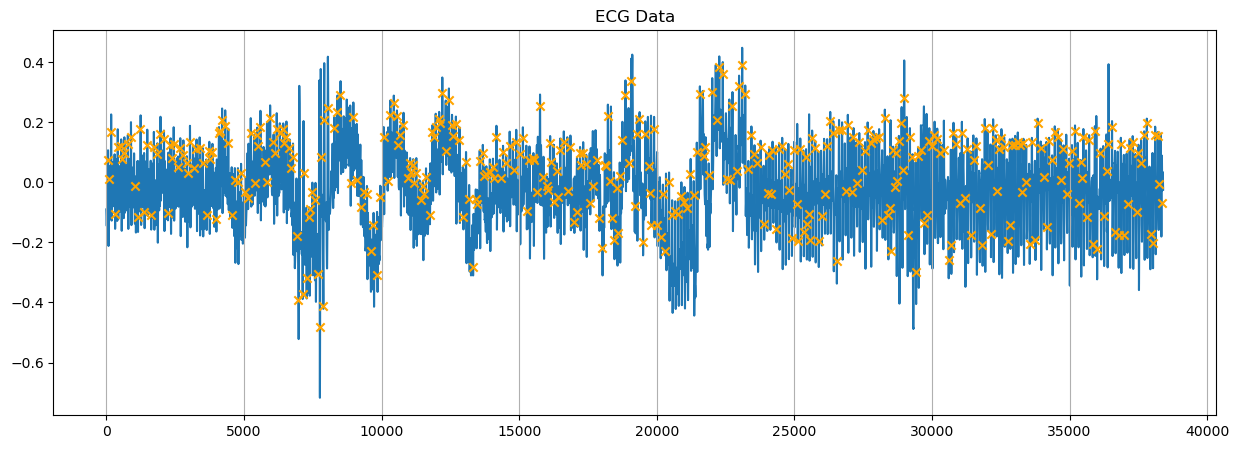

------------------------------------------------------------------------------------------------------------------------------------------------------
{'MeanRR': 0.7768668831168831, 'RMSDD': 0.37959818895053327, 'pNN50': 0.08671875, 'SDRR': 0.27709113153113085, 'CVRR': 0.035667774949989885, 'NN50': 0.333, 'MinRR': 0.3046875, 'MaxRR': 2.875}


In [151]:
def r_peak_finder_for_sym5(ecg_sig):
    BASIC_SRATE = 128
    signal_pad_samples = 10
    signal_pad = np.zeros(signal_pad_samples)  # Pad to help detect early peaks
    scd_30_denoised_ = ...  # Your denoised 30-min ECG segment
    
    # Initialize the detectors at the given sampling rate
    detector_obj = Detectors(BASIC_SRATE)
    
    # Dictionary of detector functions
    detectors = {
        'pan_tompkins_detector': detector_obj.pan_tompkins_detector,
        'hamilton_detector': detector_obj.hamilton_detector,
        'christov_detector': detector_obj.christov_detector,
        'engzee_detector': detector_obj.engzee_detector,
        'swt_detector': detector_obj.swt_detector,
        'two_average_detector': detector_obj.two_average_detector,
    }
    
    r_peaks = np.array(detector_obj.hamilton_detector(np.hstack((signal_pad, ecg_sig)) )) - signal_pad_samples
    return r_peaks


scd_30_denoised_sym5 = denoise_signal(first_5min_of30, 'sym5', 8, 0, 5)
plt.figure(figsize=(13, 5))
plt.subplot()
plt.plot(scd_30_denoised_sym5)
plt.title('First 5 min before VF onset of 30 entry (128 Hz) Den')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

print('-'*150)


r_peaks_sym5 = r_peak_finder_for_sym5(scd_30_denoised_sym5)
print(r_peaks_sym5)

print('-'*150)

plt.figure(figsize=(40,6))
plt.title('r peaks')
plt.plot(scd_30_denoised_sym5,color='tab:blue',linewidth=0.8)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)



plt.figure(figsize=(40,6))
plt.title('ECG Data')
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)


plt.figure(figsize=(15,5))
plt.title('ECG Data')
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.grid(axis='x')
plt.show()


print('-'*150)



features_sym5 = compute_hrv_features(r_peaks_sym5)
print(features_sym5)

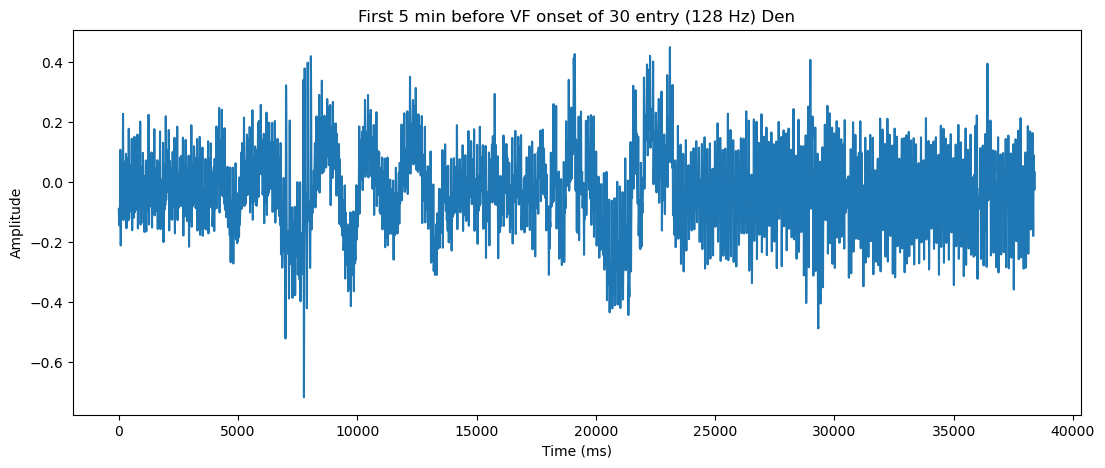

------------------------------------------------------------------------------------------------------------------------------------------------------
[   58   101   170   314   410   538   577   650   778   890  1050  1146
  1242  1386  1482  1626  1722  1850  1962  2090  2234  2330  2369  2442
  2602  2682  2794  2922  2961  3034  3194  3274  3386  3498  3642  3738
  3777  3851  3994  4090  4129  4202  4314  4426  4570  4666  4778  4891
  5050  5146  5242  5386  5482  5521  5594  5754  5850  5946  6074  6113
  6186  6299  6426  6465  6538  6651  6698  6778  6922  6981  7131  7174
  7274  7370  7409  7482  7594  7707  7754  7801  7883  7926  8042  8283
  8394  8506  8874  8970  9114  9242  9349  9466  9626  9706  9850  9947
 10074 10218 10314 10442 10555 10602 10682 10794 10954 11034 11073 11146
 11185 11258 11418 11498 11537 11611 11754 11850 11889 11962 12090 12129
 12202 12346 12442 12555 12602 12698 12826 12970 13066 13178 13322 13419
 13466 13562 13675 13722 13803 13930 14043 140

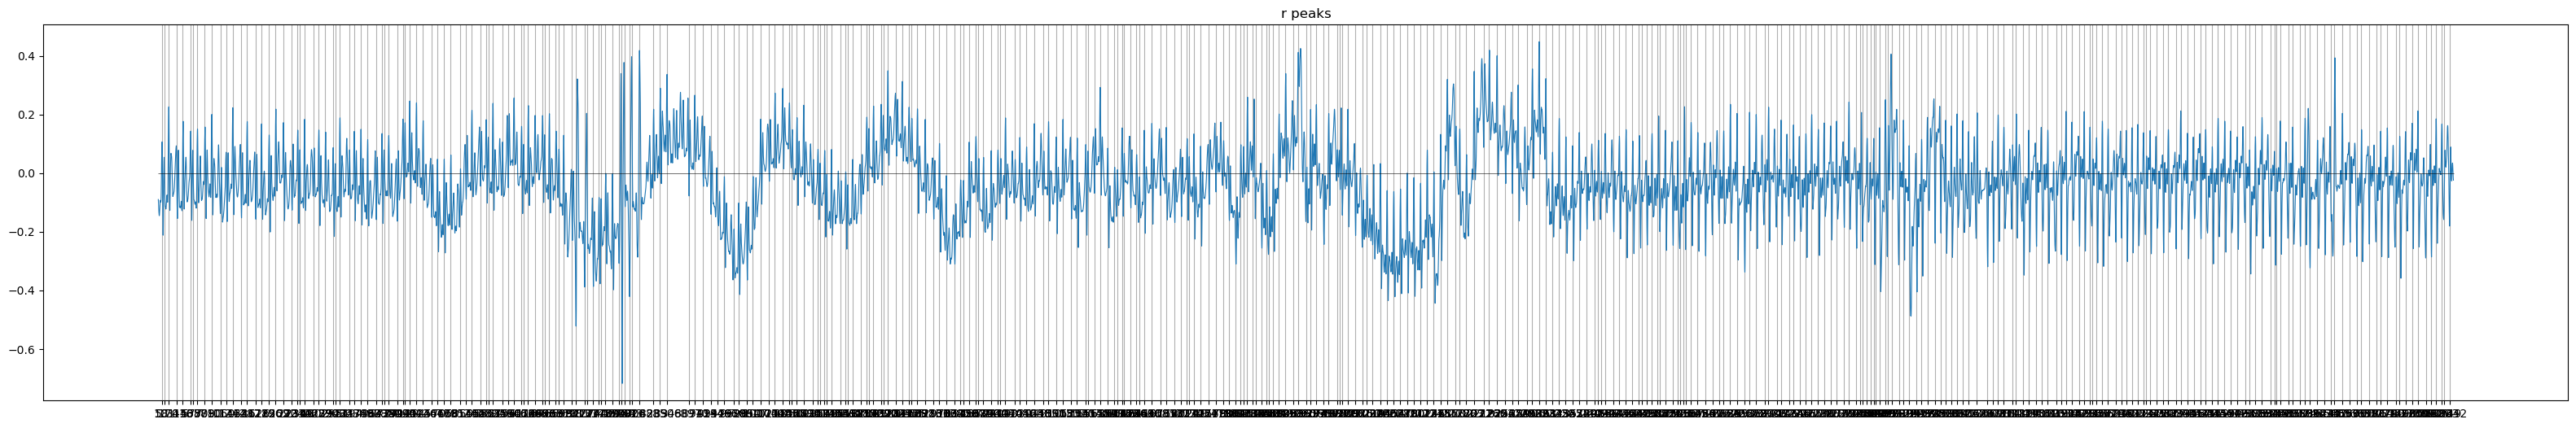

------------------------------------------------------------------------------------------------------------------------------------------------------


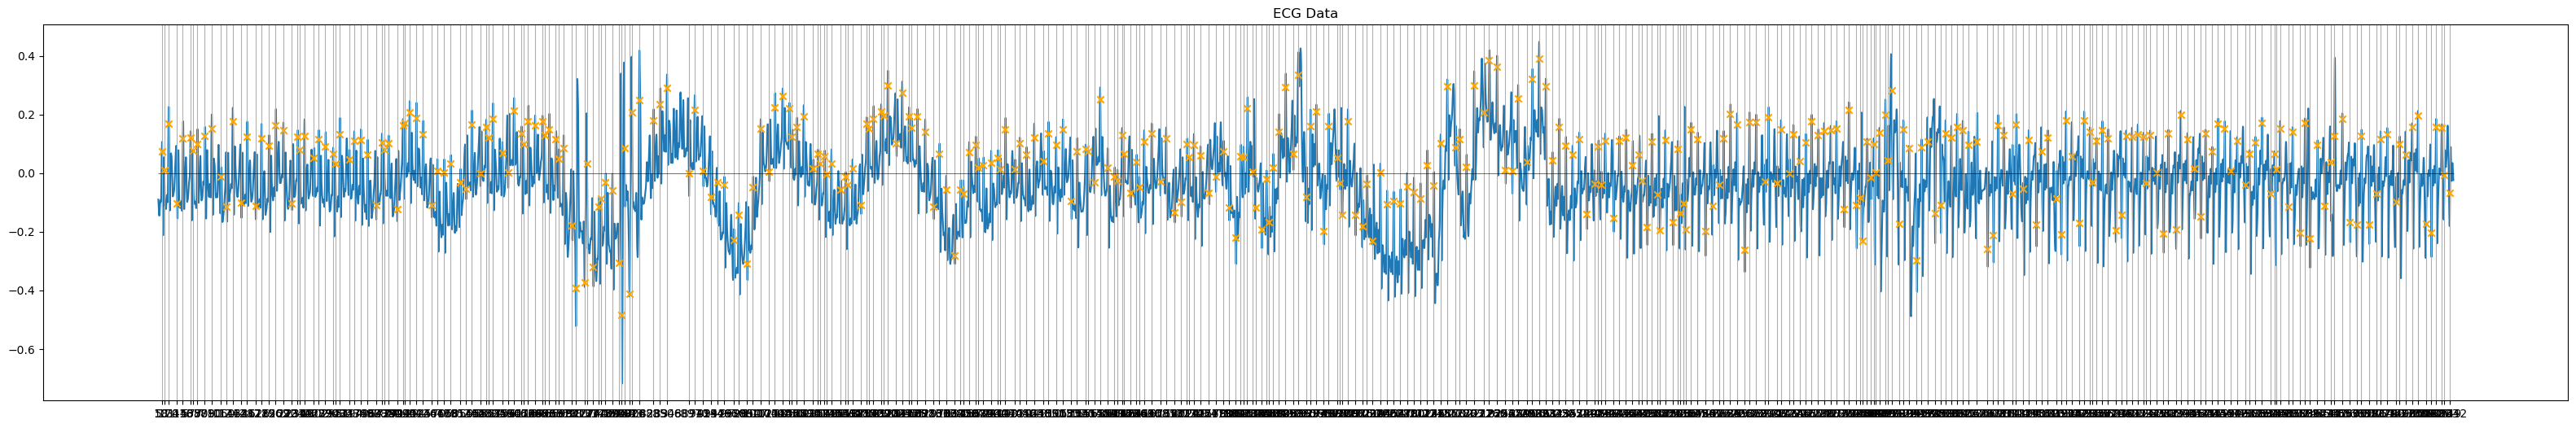

------------------------------------------------------------------------------------------------------------------------------------------------------


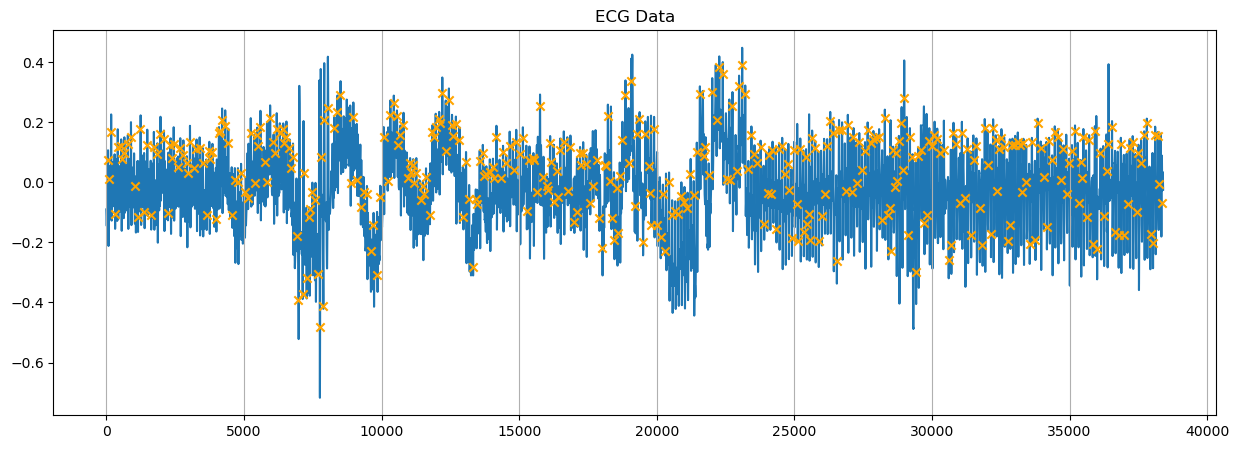

------------------------------------------------------------------------------------------------------------------------------------------------------
{'MeanRR': 0.7768668831168831, 'RMSDD': 0.37959818895053327, 'pNN50': 0.08671875, 'SDRR': 0.27709113153113085, 'CVRR': 0.035667774949989885, 'NN50': 0.333, 'MinRR': 0.3046875, 'MaxRR': 2.875}


In [171]:
def r_peak_finder_for_sym5(ecg_sig):
    BASIC_SRATE = 128
    signal_pad_samples = 10
    signal_pad = np.zeros(signal_pad_samples)  # Pad to help detect early peaks
    scd_30_denoised_ = ...  # Your denoised 30-min ECG segment
    
    # Initialize the detectors at the given sampling rate
    detector_obj = Detectors(BASIC_SRATE)
    
    # Dictionary of detector functions
    detectors = {
        'pan_tompkins_detector': detector_obj.pan_tompkins_detector,
        'hamilton_detector': detector_obj.hamilton_detector,
        'christov_detector': detector_obj.christov_detector,
        'engzee_detector': detector_obj.engzee_detector,
        'swt_detector': detector_obj.swt_detector,
        'two_average_detector': detector_obj.two_average_detector,
    }
    
    r_peaks = np.array(detector_obj.hamilton_detector(np.hstack((signal_pad, ecg_sig)) )) - signal_pad_samples
    return r_peaks


scd_30_denoised_sym5 = denoise_signal(first_5min_of30, 'sym5', 8, 0, 5)
plt.figure(figsize=(13, 5))
plt.subplot()
plt.plot(scd_30_denoised_sym5)
plt.title('First 5 min before VF onset of 30 entry (128 Hz) Den')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

print('-'*150)


r_peaks_sym5 = r_peak_finder_for_sym5(scd_30_denoised_sym5)
print(r_peaks_sym5)

print('-'*150)

plt.figure(figsize=(40,6))
plt.title('r peaks')
plt.plot(scd_30_denoised_sym5,color='tab:blue',linewidth=0.8)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)



plt.figure(figsize=(40,6))
plt.title('ECG Data')
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)


plt.figure(figsize=(15,5))
plt.title('ECG Data')
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.grid(axis='x')
plt.show()


print('-'*150)



features_sym5 = compute_hrv_features(r_peaks_sym5)
print(features_sym5)

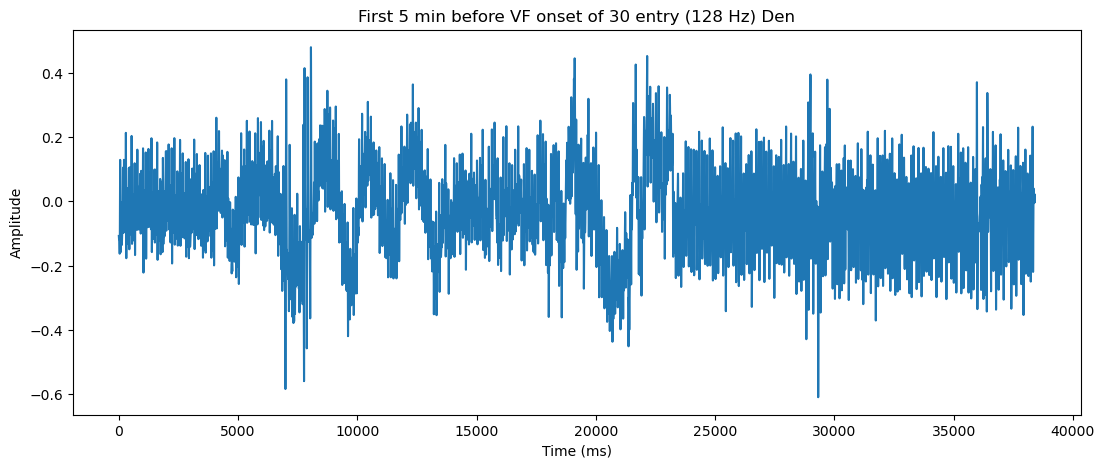

------------------------------------------------------------------------------------------------------------------------------------------------------
[  295   536   662   776  1015  1049  1128  1288  1368  1493  1529  1607
  1769  1974  2009  2088  2184  2215  2295  2328  2453  2489  2536  2567
  2602  2807  2841  2920  3080  3159  3272  3545  3624  3863  3976  4088
  4360  4473  4552  4824  4902  4937  5015  5128  5254  5289  5368  5480
  5640  5719  5958  6072  6232  6311  6424  6584  6663  6698  6824  6904
  6964  7015  7111  7223  7256  7336  7368  7448  7480  7686  7861  7913
  8054  8183  8216  8294  8329  8552  8631  8743  8777  8856  8983  9017
  9096  9223  9351  9591  9752  9832  9959 10199 10361 10440 10567 10680
 10840 10919 11032 11144 11269 11305 11383 11418 11496 11623 11658 11736
 11848 11974 12088 12249 12328 12453 12489 12567 12696 12872 12951 13064
 13112 13190 13225 13303 13431 13687 13814 14055 14216 14295 14408 14535
 14775 15016 15142 15255 15512 15640 15800 158

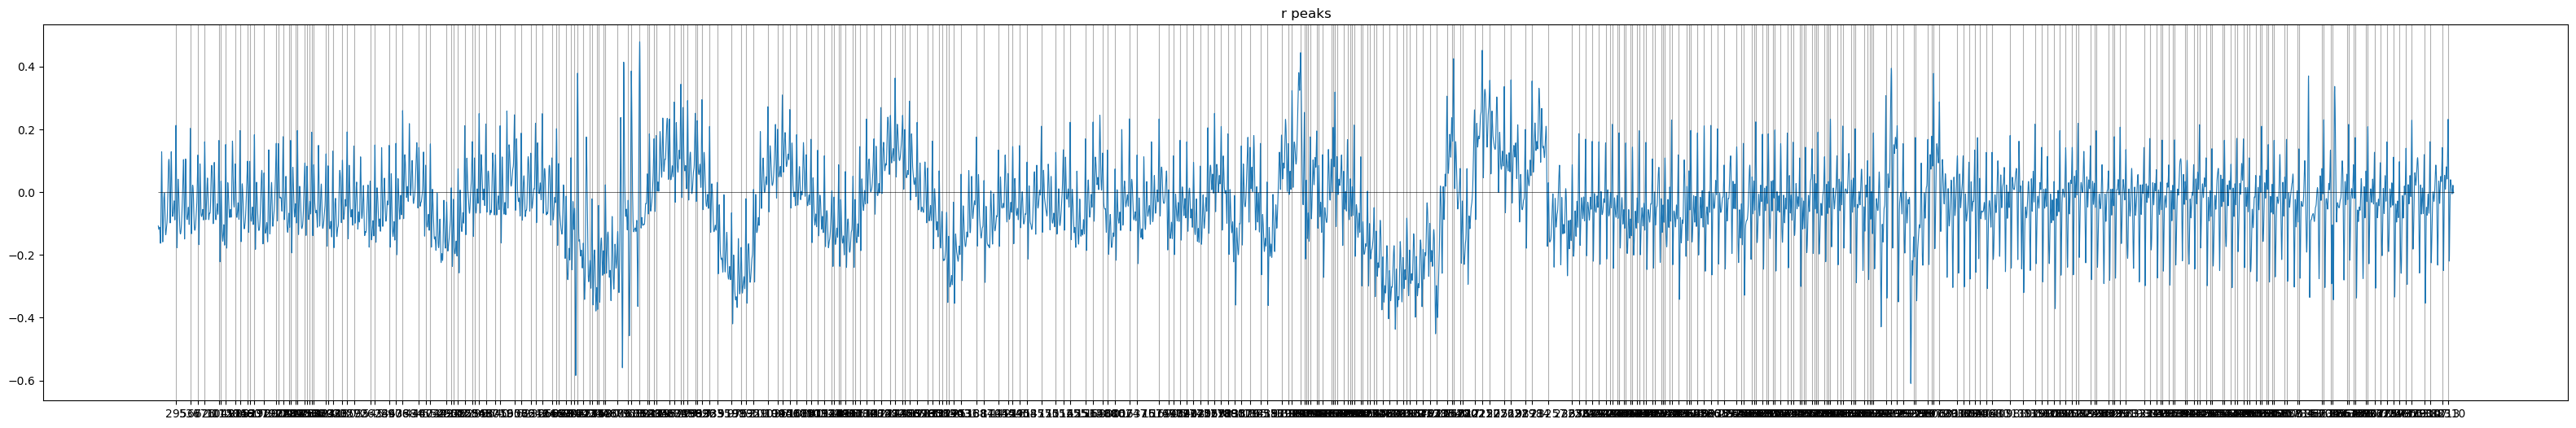

------------------------------------------------------------------------------------------------------------------------------------------------------


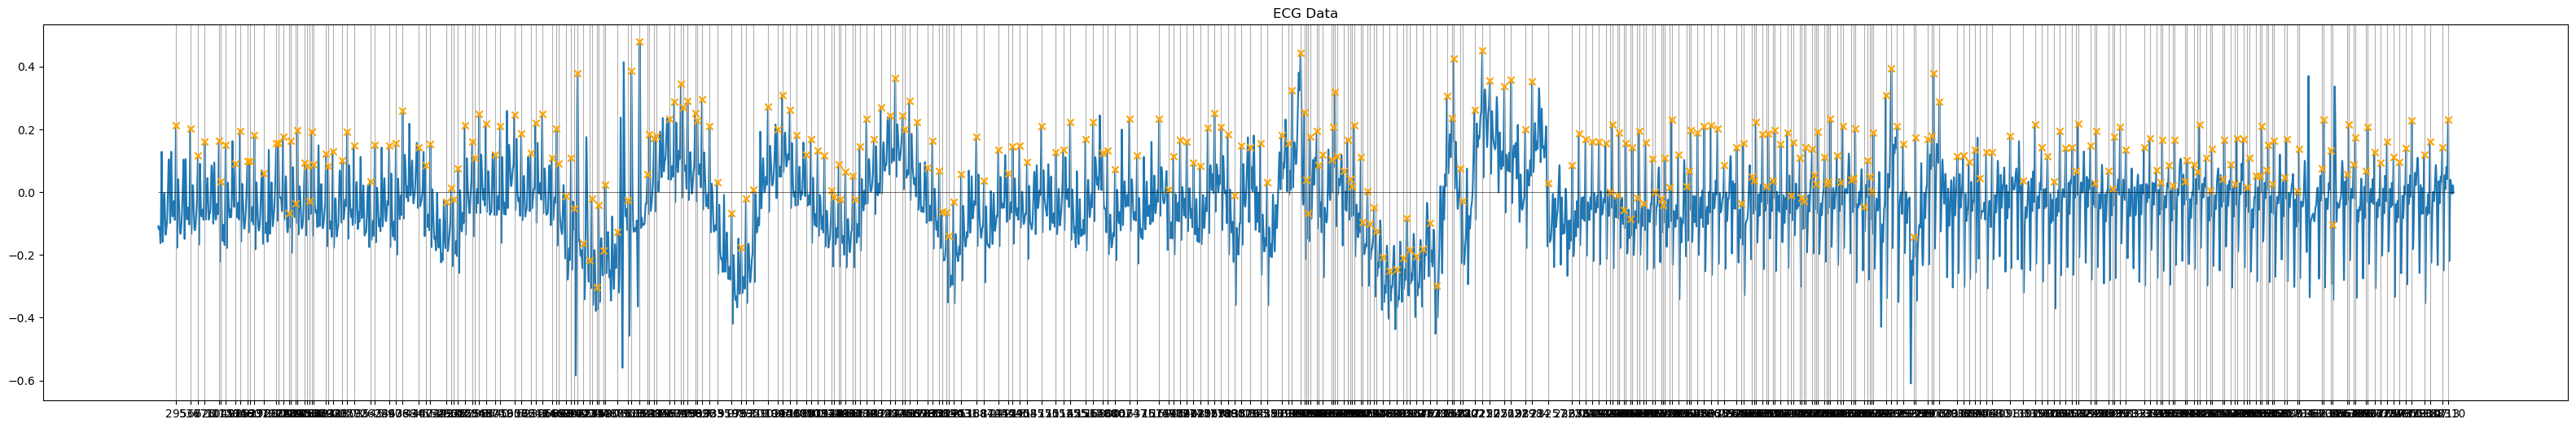

------------------------------------------------------------------------------------------------------------------------------------------------------


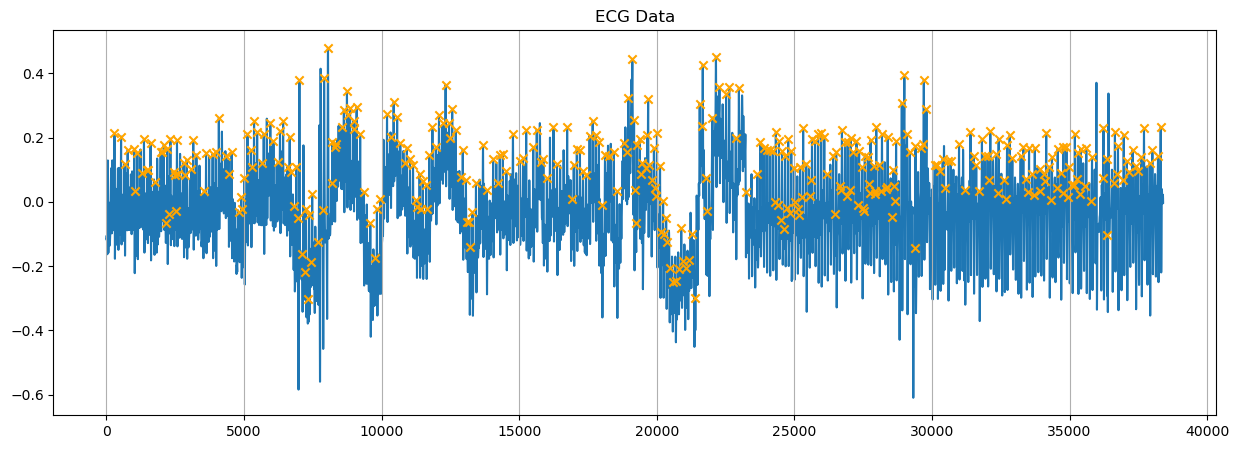

------------------------------------------------------------------------------------------------------------------------------------------------------
{'MeanRR': 0.800518025606469, 'RMSDD': 0.6949280557290504, 'pNN50': 0.08675675675675676, 'SDRR': 0.5160436607894788, 'CVRR': 0.0644637152796811, 'NN50': 0.321, 'MinRR': 0.2265625, 'MaxRR': 3.1171875}


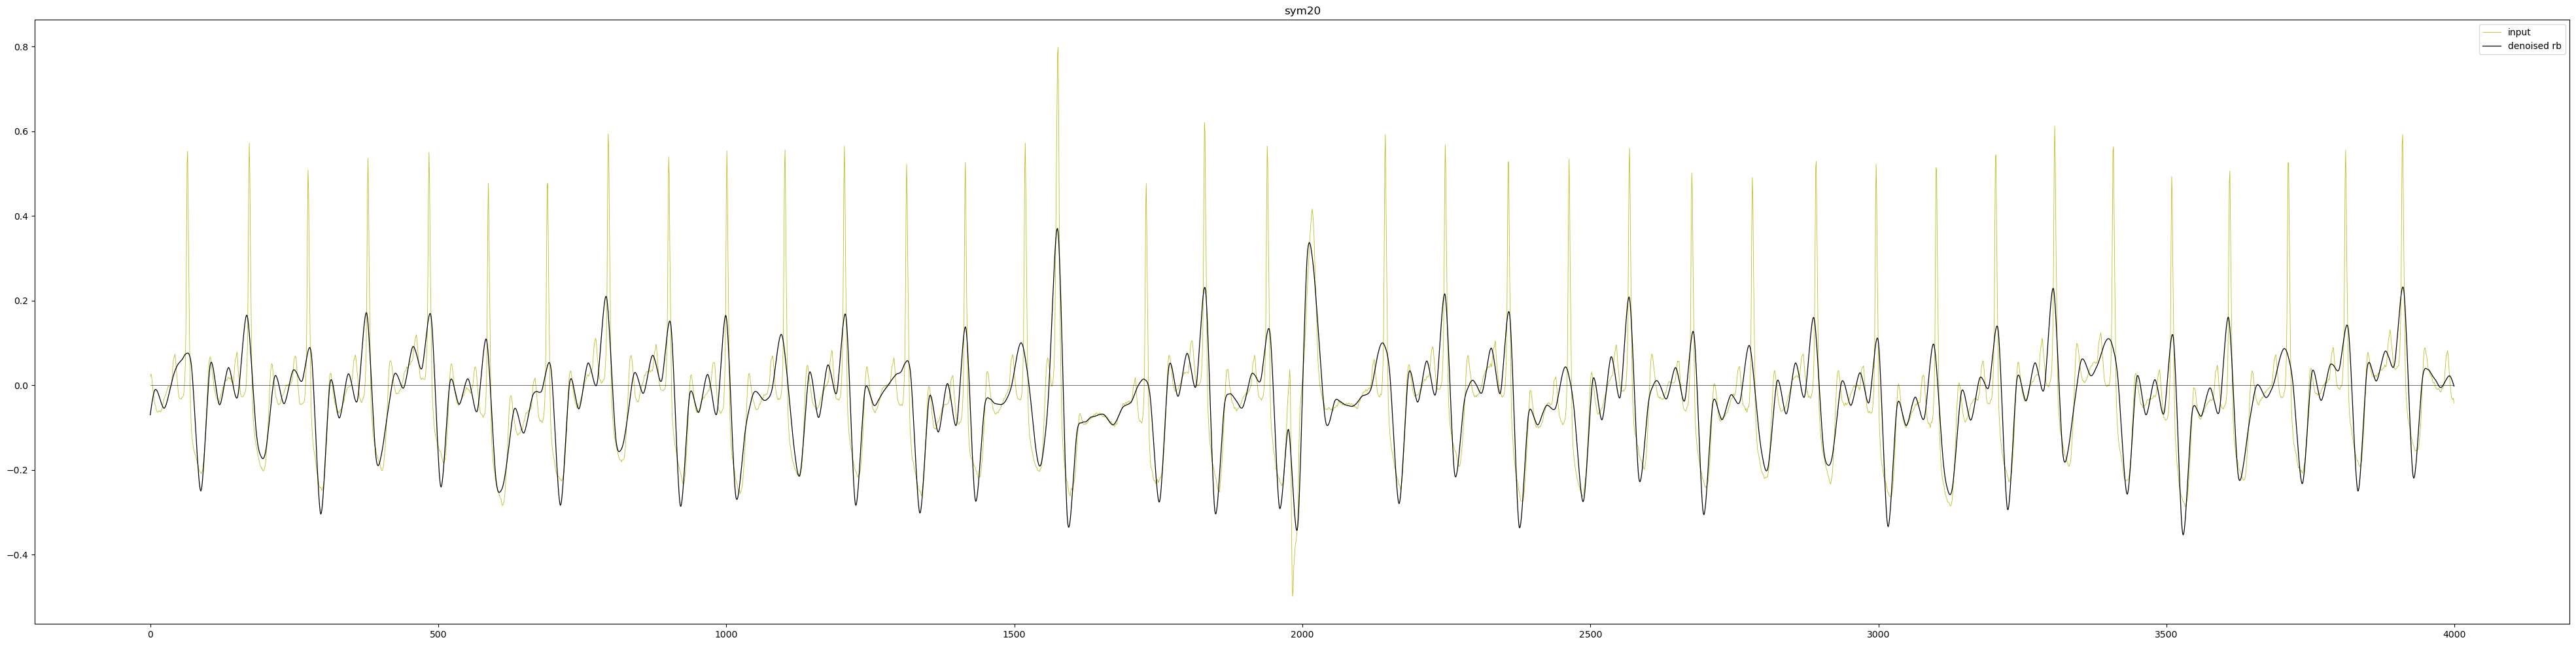

In [202]:

def r_peak_finder_for_sym5(ecg_sig):
    BASIC_SRATE = 128
    signal_pad_samples = 10
    signal_pad = np.zeros(signal_pad_samples)  # Pad to help detect early peaks
    scd_30_denoised_ = ...  # Your denoised 30-min ECG segment
    
    # Initialize the detectors at the given sampling rate
    detector_obj = Detectors(BASIC_SRATE)
    
    # Dictionary of detector functions
    detectors = {
        'pan_tompkins_detector': detector_obj.pan_tompkins_detector,
        'hamilton_detector': detector_obj.hamilton_detector,
        'christov_detector': detector_obj.christov_detector,
        'engzee_detector': detector_obj.engzee_detector,
        'swt_detector': detector_obj.swt_detector,
        'two_average_detector': detector_obj.two_average_detector,
    }
    
    r_peaks = np.array(detector_obj.engzee_detector(np.hstack((signal_pad, ecg_sig)) )) - signal_pad_samples
    return r_peaks


scd_30_denoised_sym5 = denoise_signal(first_5min_of30, 'bior6.8', 8, 0, 5)
plt.figure(figsize=(13, 5))
plt.subplot()
plt.plot(scd_30_denoised_sym5)
plt.title('First 5 min before VF onset of 30 entry (128 Hz) Den')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

print('-'*150)


r_peaks_sym5 = r_peak_finder_for_sym5(scd_30_denoised_sym5)
print(r_peaks_sym5)

print('-'*150)

plt.figure(figsize=(40,6))
plt.title('r peaks')
plt.plot(scd_30_denoised_sym5,color='tab:blue',linewidth=0.8)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)



plt.figure(figsize=(40,6))
plt.title('ECG Data')
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(r_peaks_sym5)
plt.grid(axis='x')
plt.show()


print('-'*150)


plt.figure(figsize=(15,5))
plt.title('ECG Data')
plt.scatter(r_peaks_sym5, scd_30_denoised_sym5[r_peaks_sym5], color='orange', marker='x', label='R-peaks', zorder=2)
plt.plot(scd_30_denoised_sym5, zorder=1)
plt.grid(axis='x')
plt.show()


print('-'*150)

plt.figure(figsize=(50,12))
plt.plot(first_5min_of30[-4000:], color='tab:olive', linewidth=0.6,label = 'input')
plt.plot(scd_30_denoised_sym5[-4000:], color='black', linewidth=0.9,label = 'denoised rb')
plt.title(f'sym20')
plt.hlines(0,0,4000,color='black', linewidth=0.4)
plt.legend()

features_sym5 = compute_hrv_features(r_peaks_sym5)
print(features_sym5)